# Data Generation Procedure
1. Make an outcome function of the covariates. This functional relationship is the same for all units.

For each unit:

2. Each covariate is a arma process with lag 1 and 0.9 correlation, moving average =1, with a random starting point in the range 10, 1000.
3. Once all covariates have been computed for all all time steps, the outcome for each timestep is computed by inputting the covariate values into the outcome function.
4. Append to the bottom of the dataset.

In [334]:
import statsmodels as sm
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
import pandas as pd
import random
import itertools
import string

class SimulateData(object):
    
    def __init__(self, n_donors, n_components, n_periods, treatment_period, treatment_effect):
        self.n_donors = n_donors
        self.n_components = n_components
        self.n_periods = n_periods
        
        assert treatment_period <= n_periods, "Treatment period must be 0< && <n_periods"
        self.treatment_period = treatment_period
        self.treatment_effect = treatment_effect

        self.component_count = 0
        self.index_count = 0
        self.coeffs = None
        self.dataset = None
        self.real_treatment_effect = None

    def make_component(self):
        #ar = np.r_[1, 0.9] #autoregressive component
        #ma = np.array([2]) #moving-average component
        #arma_process = ArmaProcess(ar, ma) #Define ARMA process
        #arma_component = arma_process.generate_sample(nsample=self.n_periods) #Sample arma process
        
        additive_trend = np.random.normal(0, 300)
        trend = np.array([additive_trend*x for x in range(self.n_periods)])
        
        return random.randrange(10000, 10500) + trend #np.add(arma_component, trend)
    
    def make_outcome_func(self, order):
        '''
        Chooses a subset of all possible terms of order<=order for n_components,
        Generates a random coefficient for each term, sampled from a lognormal(0, 25).
        Returns two 1-d arrays of equal size:
        terms with the indices of components that are to be multiplied
        coeffs with the coefficient by which the product of components will be weighted.
        
        order: Type:int. Gives the highest order terms that can be in the outcome function.
        For example, (x1, x1, x1) is a 3rd order term and (x1, x1) is a second order term.  
        Coefficients ~lognormal(0, 25) and divided by the order of the term to which they correspond
        '''
        
        #Record settings with which outcome func was created
        self.order = order
        
        #All first order terms are always included
        terms = list(range(self.n_components))
                
        #Generate list of all possible terms of 1< && <=self.order, given the number of components
        if self.order > 1:
            possible_terms = []
            for i in range(2, self.order+1):
                for term in itertools.combinations_with_replacement(list(range(self.n_components)), i):
                    possible_terms.append(term)
            #Select a subset of the possible terms to add to terms
            k = random.randint(1, len(possible_terms))
            higher_order_terms = random.sample(possible_terms, k)
            [terms.append(higher_order_terms[i]) for i in range(k)]

        #Create a random coeff for each term
        #Sampled from lognormal because coefficients are multiplicative
        coeffs = np.random.lognormal(0, 0.25, size=len(terms))
        for i in range(len(coeffs)):
            try: #If terms[i] has is of order 2<=, 
                 #divide by order of magnitude of covariate values ^ order
                 #Ensures contribution to outcome is of same order of magnitude as order1 terms
                coeffs[i] /= (10000 ** len(terms[i]))
            except: #if term[i] is first order, divide by 1
                continue
                
        #Store terms and coeff
        self.terms = terms
        self.coeffs = coeffs

    def compute_outcome(self, components, treated=False):
        '''
        Mutliplies each term by the associated coefficient for each observation
        Stores resulting value in outcome column y
        '''
        components = pd.DataFrame(np.array(components).T)
        
        result = np.zeros(components.shape[0])
        for coeff, term in zip(self.coeffs, self.terms):
            #If there term is only one component
            try:
                result += coeff * components.iloc[:, term]
                
            #If the term is multiple components
            except: 
                result += coeff * np.prod(components.iloc[:, list(term)], axis = 1)
                
        if treated: #Add the treatment effect for each observation in the post-treatment period
            true_counterfactual = result[self.treatment_period:]
            result[self.treatment_period:] *=  (1 + self.treatment_effect)
            self.real_treatment_effect = result[self.treatment_period:] - true_counterfactual
            
        return result

    def simulate_data(self, order):
        '''
        Makes data a panel dataset with treated unit 
        
        Format:
        Index, ID, Time, y, x1, x2,..., x_n
        '''
        #Set order and compute outcome func
        self.make_outcome_func(order)
        
        #Variables that are the same for each variable
        component_names = ["x%d"%num for num in range(self.n_components)]
        time = [x for x in range(self.n_periods)]

        #Make Treated unit
        components = [self.make_component() for _ in range(self.n_components)]
        dataset_dict = {component_names[x]: components[x] for x in range(self.n_components)}
        
        indices = [idx for idx in range(self.n_periods)]
        treated_id = np.full(self.n_periods, string.ascii_uppercase[0]) #Letter in Alphabet: A
        id_num = np.full(self.n_periods, 0)
        outcome = self.compute_outcome(components, True)
        self.dataset = pd.DataFrame({"ID_num": id_num,
                                    "ID":treated_id, 
                                     "Time":time, 
                                     "y":outcome},
                                     index=indices)
        
        #Make dataset
        temp_df = pd.DataFrame(dataset_dict, index=indices)
        self.dataset = pd.concat([self.dataset, temp_df], axis=1)

        #Make Control Units and concatenate to dataframe
        for donor in range(1, self.n_donors+1):
            components = [self.make_component() for _ in range(self.n_components)]
            donor_id = [string.ascii_uppercase[donor] for _ in range(self. n_periods)]
            id_num = [donor for _ in range(self. n_periods)]
            outcome = list(self.compute_outcome(components, False))
            indices = [idx for idx in range(donor*self.n_periods, (donor+1)*self.n_periods)]
            temp_df1 = pd.DataFrame({"ID_num": id_num,
                                    "ID":donor_id, 
                                     "Time":time, 
                                     "y":outcome},
                                     index=indices)

            dataset_dict = {component_names[x]: components[x] for x in range(self.n_components)}
            temp_df2 = pd.DataFrame(dataset_dict, index=indices)
            #Append time and unit ID and Outcome to Dataframe
            control_df = pd.concat([temp_df1, temp_df2], axis=1)

            #Concatenate control_df to self.dataset
            self.dataset = pd.concat([self.dataset, control_df], sort=False)

# Optimzation

In [397]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
from scipy.optimize import minimize, differential_evolution


class ControlSolver(object):
    
    def __init__(self, dataset, outcome_var, id_var, time_var, treatment_period, treated_unit, true_counterfactual=None):
        '''
        INPUT VARIABLES:
        
        dataset: the dataset for the synthetic control procedure.
        Should have the the following column structure:
        ID, Time, outcome_var, x0, x1,..., xn
        Each row in dataset represents one observation.
        The dataset should be sorted on ID then Time. 
        That is, all observations for one unit in order of Time, 
        followed by all observations by the next unit also sorted on time
        
        ID: a string containing a unique identifier for the unit associated with the observation.
        E.g. in the simulated datasets provided, the ID of the treated unit is "A".
        
        Time: an integer indicating the time period to which the observation corresponds.
        
        treated_unit: ID of the treated unit
        '''
        
        self.dataset = dataset
        self.y = outcome_var
        self.id = id_var
        self.time = time_var
        self.treatment_period = treatment_period
        self.treated_unit = treated_unit
        self.treatment_effect = np.array(treatment_effect) #If known
        #All columns not y, id or time must be predictors
        self.covariates = [col for col in self.dataset.columns if col not in [self.y, self.id, self.time]]

        #Extract quantities needed for reshaping matrices
        #Get number of periods in pre-treatment and total
        self.periods_pre_treatment = self.treatment_period - min(self.dataset[self.time])
        self.periods_all = max(self.dataset[self.time]) - min(self.dataset[self.time]) + 1
        #Number of control units, -1 to remove treated unit
        self.n_controls = len(self.dataset[self.id].unique()) - 1
        self.n_covariates = len(self.covariates)
        
        '''
        PROCESSED VARIABLES:
        
        treated_outcome: a (1 x treatment_period) matrix containing the
        outcome of the treated unit for each observation in the pre-treatment period.
        Referred to as Z1 in Abadie, Diamond, Hainmueller.
        
        control_outcome: a ((len(unit_list)-1) x treatment_period) matrix containing the
        outcome of every control unit for each observation in the pre-treatment period
        Referred to as Z0 in Abadie, Diamond, Hainmueller.
        
        treated_outcome_all: a (1 x len(time)) matrix
        same as treated_outcome but includes all observations, including post-treatment
        
        control_outcome_all: a (n_controls x len(time)) matrix
        same as control_outcome but includes all observations, including post-treatment
        
        treated_covariates: a (1 x len(covariates)) matrix containing the
        average value for each predictor of the treated unit in the pre-treatment period
        Referred to as X1 in Abadie, Diamond, Hainmueller.
        
        control_covariates: a (n_controls x len(covariates)) matrix containing the
        average value for each predictor of every control unit in the pre-treatment period
        Referred to as X0 in Abadie, Diamond, Hainmueller.
        
        W: a (1 x n_controls) matrix containing the weights assigned to each
        control unit in the synthetic control. W is contstrained to be convex,
        that is sum(W)==1 and ∀w∈W, w≥0, each weight is non-negative and all weights sum to one.
        Referred to as W in Abadie, Diamond, Hainmueller.
        
        V: a (len(covariates) x len(covariates)) matrix representing the relative importance
        of each covariate. V is contrained to be diagonal, positive semi-definite. 
        Pracitcally, this means that the product V.control_covariates and V.treated_covariates
        will always be non-negative. Further, we constrain sum(V)==1, otherwise there will an infinite
        number of solutions V*c, where c is a scalar, that assign equal relative importance to each covariate
        Referred to as V in Abadie, Diamond, Hainmueller.
        '''
        self.treated_outcome = None
        self.control_outcome = None
        self.treated_covariates = None
        self.control_covariates = None
        self.w = None
        self.v = None
        
        
        self.treated_outcome_all = None
        self.control_outcome_all = None
    
    
    def preprocess_data(self):
        '''
        Extracts processed variables from, excluding v and w, from input variables.
        These are all the data matrices.
        '''

        ###Get treated unit matrices first###
        treated_data_all = self.dataset[self.dataset[self.id] == self.treated_unit]
        self.treated_outcome_all = np.array(treated_data_all[self.y]).reshape(self.periods_all, 1) #All outcomes
        
        #Only pre-treatment
        treated_data = treated_data_all[self.dataset[self.time] < self.treatment_period]
        #Extract outcome and shape as matrix
        self.treated_outcome = np.array(treated_data[self.y]).reshape(self.periods_pre_treatment, 1)
        #Columnwise mean of each covariate in pre-treatment period for treated unit, shape as matrix
        self.treated_covariates = np.array(treated_data[self.covariates].mean(axis=0)).reshape(self.n_covariates, 1)
        
        ### Now for control unit matrices ###
        #Every unit that is not the treated unit is control
        control_data_all = self.dataset[self.dataset[self.id] != self.treated_unit]
        self.control_outcome_all = np.array(control_data_all[self.y]).reshape(self.periods_all, self.n_controls) #All outcomes
        
        #Only pre-treatment
        control_data = control_data_all[self.dataset[self.time] < self.treatment_period]
        #Extract outcome, then shape as matrix
        self.control_outcome = np.array(control_data[self.y]).reshape(self.periods_pre_treatment, self.n_controls)
        
        #Extract the covariates for all the control units
        #Identify which rows correspond to which control unit by setting index, 
        #then take the unitwise mean of each covariate
        #This results in the desired (n_control x n_covariates) matrix
        self.control_covariates = np.array(control_data[self.covariates].\
                set_index(np.arange(len(control_data[self.covariates])) // self.periods_pre_treatment).\
                mean(level=0)).T
        
    def total_loss(self, v_0, optimize=True):
        '''
        Solves for w*(v) that minimizes loss function 1 given v,
        Returns loss from loss function 2 with w=w*(v)
        '''
        V = np.zeros(shape=(self.n_covariates, self.n_covariates))
        np.fill_diagonal(V, v_0)
        
        # Construct the problem - constrain weights to be non-negative
        w = cvx.Variable((self.n_controls, 1), nonneg=True)
        
        #Define the objective
        objective = cvx.Minimize(cvx.sum(V @ cvx.square(self.treated_covariates - self.control_covariates @ w)))
        
        #Add constraint sum of weights must equal one
        constraints = [cvx.sum(w) == 1]
        
        #Solve problem
        problem = cvx.Problem(objective, constraints)
        result = problem.solve(verbose=False)
        
        loss = (self.treated_outcome - self.control_outcome @ w.value).T @ (self.treated_outcome - self.control_outcome @ w.value)
        
        #If optimize is true, just return the loss
        if optimize:
            return loss
        
        else:
            #print("Total loss:", np.round(loss, 3))
            #print("Optimal w:", np.round(w.value, 3))
            return w.value, loss
    
    
    def optimize(self, steps):
        #Initalize variable to track best w*(v)
        best_w, min_loss = None, float(np.inf)
        
        for step in range(steps):

            #Dirichlet distribution returns a valid pmf over n_covariates states
            v_0 = np.random.dirichlet(np.ones(self.n_covariates), size=1)

            #Required to have non negative values
            bnds = tuple((0,1) for _ in range(self.n_covariates))

            #res = minimize(self.total_loss, v_0, bounds=bounds, method="L-BFGS-B")
            res = minimize(self.total_loss, v_0, method='L-BFGS-B', bounds=bnds, tol=1e-20, 
                          options={'disp':3, 'iprint':3, 'maxfun': 150000, 'maxiter': 150000}) #, constraints=cons) method='L-BFGS-B'

            print("Successful:", res.success)

            #If optimization was successful
            if res.success:
                #Compute w*(v) and loss for v
                w, loss = self.total_loss(res.x, False)

                #See if w*(v) results in lower loss, if so update best
                if loss < min_loss:
                    best_w, min_loss = w, loss
                    
                    #Store best v from optimization
                    self.v = res.x               
        
        #If sampler did not converge
        try:
            best_w[0]
        except:
            return print("Did not converge", res.message)

        #Save best w
        self.w = best_w
        
        #Return w*(v) and total loss
        return self.v, self.w, min_loss
    
    def diffevo_optimize(self):
        '''Uses the differential evolution optimizer from scipy to solve for synthetic control'''
        bounds = [(0,1) for _ in range(self.n_covariates)]

        #def constr_f(x): return np.sum(x)
        #lc = NonlinearConstraint(constr_f, 0, 1)
        #result = scipy.optimize.differential_evolution(total_loss_func, bounds, constraints=(lc))

        result = differential_evolution(self.total_loss, bounds)
        
        self.v = result.x
        
        self.w, loss = self.total_loss(self.v, False)
        
        return self.w, loss


    def random_optimize(self, steps=10**4):
        '''
        "When intelligent approaches fail, throw spaghetti at the wall and see what sticks" - Benito Mussolini
        
        The below random samples valid v matrices from dirichlet distribution,
        then computes the resulting w*(v) and the total loss associated with it
        
        Returns the w*(v) that minimizes total loss
        '''
        #Initalize variable to track best w*(v)
        best_w, min_loss = None, float(np.inf)
        for i in range(steps):
            
            #Generate sample v
            #Dirichlet distribution returns a valid pmf over n_covariates states
            v = np.random.dirichlet(np.ones(self.n_covariates), size=1)
            
            #Print progress
            if (i+1)%steps/10 == 0:
                print('{}%'.format((i+1)%steps/10))
            
            #Compute w*(v) and loss for v
            w, loss = self.total_loss(v, False)
            
            #See if w*(v) results in lower loss, if so update best
            if loss < min_loss:
                best_w, min_loss = w, loss
        
        
        #Store, print, return best solutions
        self.w = best_w
        print("Total loss:", np.round(min_loss, 3))
        print("Optimal w:", np.round(self.w, 3))
        
        return best_w, min_loss
    
    
    def get_post_treatment_rmspe(self):
        '''
        Computes post-treatment outcome for treated and synthetic control unit
        Subtracts treatment effect from treated unit
        
        Returns post-treatment RMSPE for synthetic control.
        Required: self.w must be defined.
        '''
        try:
            self.w[0]
        except:
            return "W not defined: run optimise() first!"
        
        #Get true counter factual by subtracting the treatment effect from the treated unit
        true_counterfactual = self.treated_outcome_all[self.treatment_period:] - self.treatment_effect
        synth = self.control_outcome_all[self.treatment_period:] @ self.w
        return np.sqrt(((true_counterfactual - synth) ** 2).mean())
    
    def plot(self):
        '''Plot the outcome of the Synthetic Unit against the Treated unit'''
        
        synth = self.w.T @ self.control_outcome_all
        print(self.control_outcome_all)
        print(synth)
        time = self.dataset[self.time].unique()
        plt.plot(time, synth, 'r--', label="Synthetic Control")
        plt.plot(time ,self.treated_outcome_all, 'b-', label="Actual Data")
        plt.title("Example Synthetic Control Model")
        plt.ylabel(self.y)
        plt.xlabel(self.time)
        plt.legend(loc='upper left')
        plt.show()

In [391]:
#(self, n_donors, n_components, n_periods, treatment_period, treatment_effect)
data_generator = SimulateData(24, 1, 20, 15, 0.2)
data_generator.simulate_data(order=1)
data = data_generator.dataset
real_treatment_effect = data_generator.real_treatment_effect #COMPUTE FROM FUNC

In [376]:
solver = ControlSolver(data, "y", "ID", "Time", 5, "A", real_treatment_effect)
solver.preprocess_data()
solver.optimize(5)

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Successful: True
Successful: True
Successful: True
Successful: True
Successful: True


(array([1., 0.]), array([[1.00000000e+00],
        [2.48067266e-23],
        [1.77031430e-23],
        [1.76235681e-23],
        [1.83015698e-23],
        [1.75147269e-23],
        [1.38620482e-23],
        [2.03462362e-23],
        [1.71272929e-23],
        [1.88998412e-23],
        [2.04735441e-23],
        [1.77700565e-23],
        [1.64515881e-23],
        [1.53932806e-23],
        [1.77173014e-23],
        [1.80430829e-23],
        [1.56649317e-23],
        [1.44414202e-23],
        [1.66345238e-23],
        [1.59422619e-23],
        [1.70197494e-23],
        [1.62671462e-23],
        [1.75582090e-23],
        [1.75507963e-23]]), array([[1611979.08303129]]))

In [374]:
print(np.round(solver.w.T, 3))
solver.get_post_treatment_rmspe()

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


3115.7026922299497

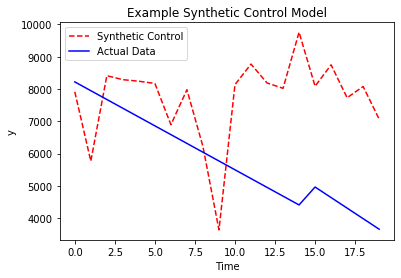

In [375]:
solver.plot()

In [398]:
data = pd.read_csv("/Users/oscarengelbrektson/Downloads/german_reunification.csv")

In [399]:
solver = ControlSolver(data, "gdp", "country", "year", 1990, "West Germany", real_treatment_effect)
solver.preprocess_data()
solver.diffevo_optimize()

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(array([[0.24811079],
        [0.        ],
        [0.22276373],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.52912547]]), array([[9.91498906e+08]]))

In [401]:
print(np.round(solver.w, 3))
print(np.round(solver.v, 3))
solver.plot()

[[0.248]
 [0.   ]
 [0.223]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.   ]
 [0.529]]
[0.042 0.023 1.    0.677 1.    0.    0.    0.   ]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 44 is different from 16)

In [420]:
solver.control_outcome_all.T.shape

(16, 44)

In [421]:
solver.w.T @ solver.control_outcome_all.T

array([[ 5384.04127938, 16776.12233569, 13284.54954496,  5469.83202815,
        14827.01782459, 11772.38405706,  8456.88963046, 20734.05537041,
        15890.9247322 , 10334.54927154, 24065.70128033,  4645.22412554,
        13831.67410134, 10918.47870043,  5929.5924574 , 16498.05494639,
        12356.42682956,  7774.42747992, 19119.29833609, 14966.52643826,
        10651.04244253, 24969.95993043,  3737.34553995, 13334.12901576,
        12115.80342071,  8500.29916496, 21006.94447346, 14100.65312473,
         7356.30314712, 19094.72908501, 14093.91165811,  6761.78674821,
        15926.4155845 ,  1980.71537312,  7997.78551852,  6617.83456851,
         4069.90064166, 11956.51822652, 10066.00658172,  8448.29618205,
        20400.53483418, 15789.83064685,  9623.0249106 , 19133.95763525]])